In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from world_machine_experiments.shared.save_metrics import load_multiple_metrics, get_values
from world_machine_experiments.toy1d.dimensions import Dimensions
from world_machine.train.stages import StateSaveMethod

In [2]:
metrics = load_multiple_metrics("toy1d_experiment1_configuration_test", "toy1d_metrics")
parameters = load_multiple_metrics("toy1d_experiment1_configuration_test", "parameters")
train_history = load_multiple_metrics("toy1d_experiment1_configuration_test", "toy1d_train_history")

In [31]:
list(metrics.keys()) == list(parameters.keys()), list(train_history.keys()) == list(metrics.keys())

(True, True)

In [3]:
optimizer_loss_train = get_values(train_history, ["means", "optimizer_loss_train"])
mask = np.isnan(optimizer_loss_train).sum(1) == 0

optimizer_loss_val = get_values(train_history, ["means", "optimizer_loss_val"])
mask = np.bitwise_and(mask, np.isnan(optimizer_loss_val).sum(1) == 0)

In [42]:
metric_names = ["normal", "use_state", "prediction", "prediction_shallow"]

In [ ]:
for name in metric_names:
    data = get_values(metrics, ["means",name,"state_decoded_mse"])

    mask = np.bitwise_and(mask, np.bitwise_not(np.isnan(data)))
    mask = np.bitwise_and(mask, data<10)

In [144]:
uncond_diverge_prob = 1-(mask.sum()/len(mask))
uncond_diverge_prob

0.02734375

In [32]:
names = np.array(list(metrics.keys()))
names_filtered = names[mask]

{'normal': {'state_decoded_mse': 0.007325553800910711,
  'state_decoded_0.1sdtw': 0.06570573151111603,
  'measurement_mse': 0.0038939311634749174,
  'measurement_0.1sdtw': 0.04785040020942688,
  'optimizer_loss': 0.0056097423657774925},
 'use_state': {'state_decoded_mse': 0.011795065365731716,
  'state_decoded_0.1sdtw': 0.05553058534860611,
  'measurement_mse': 0.006587090436369181,
  'measurement_0.1sdtw': 0.04469894617795944,
  'optimizer_loss': 0.009191078133881092},
 'prediction': {'state_decoded_mse': 0.12165240943431854,
  'state_decoded_0.1sdtw': 0.49990877509117126,
  'measurement_mse': 0.08007466793060303,
  'measurement_0.1sdtw': 0.609310507774353,
  'optimizer_loss': 0.10086353123188019},
 'prediction_shallow': {'state_decoded_mse': 0.20434392988681793,
  'state_decoded_0.1sdtw': 0.9818953275680542,
  'measurement_mse': 0.13009771704673767,
  'measurement_0.1sdtw': 1.19845449924469,
  'optimizer_loss': 0.1672208607196808}}

In [43]:
parameters_data = []

for name in parameters:
    item = parameters[name]["parameters"]
    item["name"] = name
    item["diverge"] = name not in names_filtered

    for m in metric_names:
        for criterion in ["mse", "0.1sdtw"]:
            item[f"{m}_{criterion}"] = metrics[name]["means"][m][f"state_decoded_{criterion}"]
    
    parameters_data.append(item)

In [44]:
df = pd.DataFrame(parameters_data)

0        True
1        True
2       False
3        True
4       False
        ...  
3067    False
3068    False
3069    False
3070     True
3071    False
Length: 3072, dtype: bool

In [109]:
df["SB_1"] = np.bitwise_and(df["n_segment"] == 2, df["fast_forward"] == False)
df["SB_2"] = np.bitwise_and(df["n_segment"] == 2, df["fast_forward"] == True)

df["SM_1"] = df["state_save_method"] == StateSaveMethod.MEAN.value
df["SM_2"] = df["check_input_masks"] == True

df["AC_1"] = pd.isnull(df["state_activation"])

df["MD_1"] = df["block_configuration"].map(lambda x : np.alltrue(x == [Dimensions.MEASUREMENT.value, Dimensions.STATE_INPUT.value]))

df["NA_1"] = df["noise_config"].map(lambda x: x is not None and "state" in x)
df["NA_2"] = df["noise_config"].map(lambda x: x is not None and "measurement" in x)

df["ST_1"] = df["recall_stride_past"] == 1
df["ST_2"] = df["recall_stride_past"] == 3
df["ST_3"] = df["recall_n_past"] == 1
df["ST_4"] = df["recall_n_past"] == 5
df["ST_5"] = df["recall_n_future"] == 1
df["ST_6"] = df["recall_n_future"] == 5

In [110]:
variables = ["SB_1", "SB_2", "SM_1", "SM_2", "AC_1", "MD_1", "NA_1", "NA_2", "ST_1", "ST_2", "ST_3", "ST_4", "ST_5", "ST_6"]

In [113]:
variable_count = []
for v in variables:
    variable_count.append(df[v].sum())

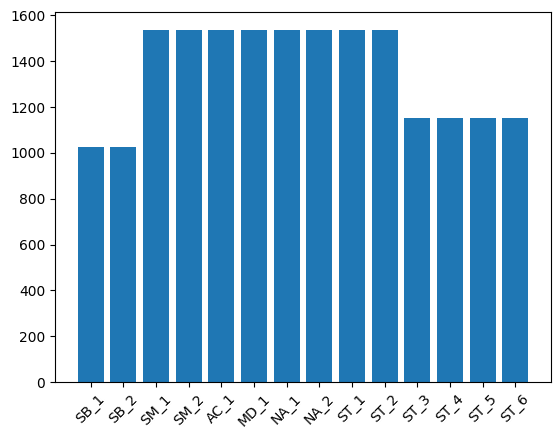

In [148]:
plt.bar(variables, variable_count)

plt.xticks(rotation=45)
plt.show()

In [143]:
diverge_prob

[0.008463541666666666,
 0.006184895833333333,
 0.025390625,
 0.01171875,
 0.02734375,
 0.027018229166666668,
 0.0,
 0.012044270833333334,
 0.015625,
 0.01171875,
 0.013671875,
 0.005208333333333333,
 0.01171875,
 0.009114583333333334]

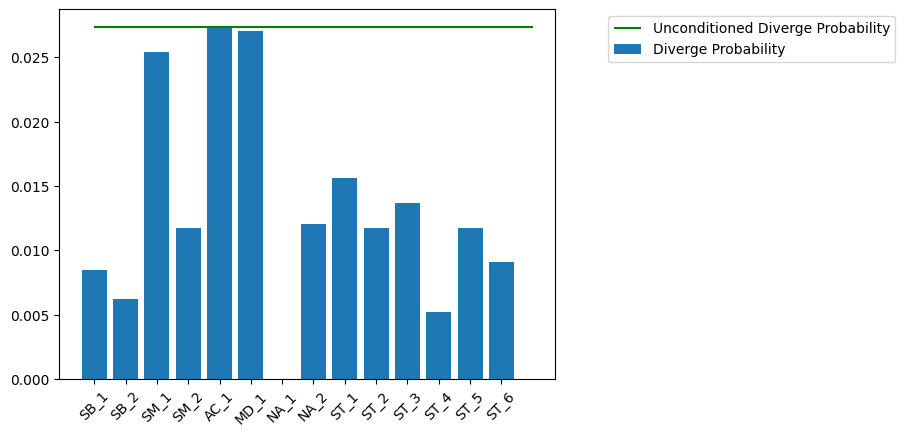

In [159]:
diverge_prob = []
for v in variables:
    prob = df[df[v]]["diverge"].sum()/len(df)

    diverge_prob.append(prob)

plt.bar(variables, diverge_prob, label="Diverge Probability")

plt.hlines([uncond_diverge_prob], 0, len(variables), colors="green", label="Unconditioned Diverge Probability")

plt.legend(bbox_to_anchor=(1.7, 1), loc='upper right')

plt.xticks(rotation=45)
plt.show()

In [166]:
variables_filtered = []

for i, v in enumerate(variables):
    if diverge_prob[i] < 0.02:
        variables_filtered.append(v)

variables_filtered

['SB_1',
 'SB_2',
 'SM_2',
 'NA_1',
 'NA_2',
 'ST_1',
 'ST_2',
 'ST_3',
 'ST_4',
 'ST_5',
 'ST_6']

In [126]:
import statsmodels.formula.api as smf

In [128]:
equation = " + ".join(variables)
equation = "normal_mse ~ "+equation
equation

'normal_mse ~ SB_1 + SB_2 + SM_1 + SM_2 + AC_1 + MD_1 + NA_1 + NA_2 + ST_1 + ST_2 + ST_3 + ST_4 + ST_5 + ST_6'

In [ ]:
df_filtered = df[df["diverge"] == False]

In [136]:
model = smf.ols(equation, data=df_filtered).fit()

In [137]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             normal_mse   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     60.69
Date:                Tue, 23 Sep 2025   Prob (F-statistic):          2.05e-141
Time:                        15:35:58   Log-Likelihood:                 11362.
No. Observations:                2988   AIC:                        -2.270e+04
Df Residuals:                    2974   BIC:                        -2.261e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0019      0.000      6.980      0.000       0.001       0.002
SB_1[T.True]     0.0024      0.000      9.968      0.000       0.002       0.003
SB_2[T.True]     0.0015      0.000      6.115      0.000       0.001       0.002
SM_1[T.True]     0.0023      0.000     11.703      0.000       0.002       0.003
SM_2[T.True]    -0.0001      0.000     -0.565      0.572      -0.001       0.000
AC_1[T.True]     0.0042      0.000     21.173      0.000       0.004       0.005
MD_1[T.True]    -0.0002      0.000     -1.015      0.310      -0.001       0.000
NA_1[T.True]     0.0013      0.000      6.446      0.000       0.001       0.002
NA_2[T.True]     0.0011      0.000      5.345      0.000       0.001       0.001
ST_1[T.True]     0.0008      0.000      4.797      0.000       0.000       0.001
ST_2[T.True]     0.0011      0.000      6.592      0.000       0.001       0.001
ST_3[T.True]     0.0005      0.000      1.760      0.079   -5.41e-05       0.001
ST_4[T.True]    -0.0005      0.000     -1.782      0.075      -0.001    4.78e-05
ST_5[T.True]    -0.0002      0.000     -0.886      0.376      -0.001       0.000
ST_6[T.True]     0.0004      0.000      1.447      0.148      -0.000       0.001
==============================================================================
Omnibus:                     7051.423   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         88534855.139
Skew:                          23.010   Prob(JB):                         0.00
Kurtosis:                     845.025   Cond. No.                     1.27e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.2e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a

- P>|t| alto -> coeficiente não é medido pelo modelo (chance da variável dependente não ser afetada por esta variável é alta)

- Prob(Ommibus) e Prob(JB) baixas -> resíduos não normalmente distribuídos -> regressão de má qualidade
- Cond. No. alto -> multicolinariedade -> variáveis não independentes

In [167]:
equation_filtered = " + ".join(variables_filtered)
equation_filtered = "normal_mse ~ "+equation_filtered
equation_filtered

'normal_mse ~ SB_1 + SB_2 + SM_2 + NA_1 + NA_2 + ST_1 + ST_2 + ST_3 + ST_4 + ST_5 + ST_6'

In [168]:
model = smf.ols(equation_filtered, data=df_filtered).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             normal_mse   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     17.84
Date:                Tue, 23 Sep 2025   Prob (F-statistic):           5.31e-32
Time:                        16:03:09   Log-Likelihood:                 11098.
No. Observations:                2988   AIC:                        -2.217e+04
Df Residuals:                    2977   BIC:                        -2.211e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0039      0.000     13.838      0.000       0.003       0.004
SB_1[T.True]     0.0025      0.000      9.260      0.000       0.002       0.003
SB_2[T.True]     0.0015      0.000      5.811      0.000       0.001       0.002
SM_2[T.True] -8.798e-05      0.000     -0.407      0.684      -0.001       0.000
NA_1[T.True]     0.0015      0.000      6.718      0.000       0.001       0.002
NA_2[T.True]     0.0011      0.000      4.985      0.000       0.001       0.002
ST_1[T.True]     0.0018      0.000      9.997      0.000       0.001       0.002
ST_2[T.True]     0.0021      0.000     11.945      0.000       0.002       0.002
ST_3[T.True]     0.0005      0.000      1.584      0.113      -0.000       0.001
ST_4[T.True]    -0.0004      0.000     -1.411      0.158      -0.001       0.000
ST_5[T.True]    -0.0003      0.000     -0.856      0.392      -0.001       0.000
ST_6[T.True]     0.0004      0.000      1.377      0.169      -0.000       0.001
==============================================================================
Omnibus:                     6499.129   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         50235087.884
Skew:                          18.964   Prob(JB):                         0.00
Kurtosis:                     637.079   Cond. No.                     1.15e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.09e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [169]:
df_filtered["normal_mse"].mean()

0.00849170980546773

In [172]:
equation_filtered_ps = " + ".join(variables_filtered)
equation_filtered_ps = "prediction_shallow_mse ~ "+equation_filtered_ps
equation_filtered_ps

model = smf.ols(equation_filtered_ps, data=df_filtered).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     prediction_shallow_mse   R-squared:                       0.126
Model:                                OLS   Adj. R-squared:                  0.124
Method:                     Least Squares   F-statistic:                     43.09
Date:                    Tue, 23 Sep 2025   Prob (F-statistic):           2.16e-80
Time:                            16:04:51   Log-Likelihood:                 5200.5
No. Observations:                    2988   AIC:                        -1.038e+04
Df Residuals:                        2977   BIC:                        -1.031e+04
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1312      0.002     64.870      0.000       0.127       0.135
SB_1[T.True]    -0.0032      0.002     -1.654      0.098      -0.007       0.001
SB_2[T.True]    -0.0143      0.002     -7.511      0.000      -0.018      -0.011
SM_2[T.True]    -0.0027      0.002     -1.731      0.083      -0.006       0.000
NA_1[T.True]     0.0278      0.002     17.840      0.000       0.025       0.031
NA_2[T.True]    -0.0079      0.002     -5.099      0.000      -0.011      -0.005
ST_1[T.True]     0.0677      0.001     52.948      0.000       0.065       0.070
ST_2[T.True]     0.0635      0.001     49.881      0.000       0.061       0.066
ST_3[T.True]     0.0017      0.002      0.797      0.426      -0.002       0.006
ST_4[T.True]     0.0032      0.002      1.520      0.129      -0.001       0.007
ST_5[T.True]     0.0011      0.002      0.522      0.602      -0.003       0.005
ST_6[T.True]     0.0057      0.002      2.701      0.007       0.002       0.010
==============================================================================
Omnibus:                      309.246   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              451.345
Skew:                           0.785   Prob(JB):                     9.81e-99
Kurtosis:                       4.079   Cond. No.                     1.15e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.09e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
df_filtered["prediction_shallow_0.1sdtw"]

In [177]:
equation_filtered_ps = " + ".join(variables_filtered)
equation_filtered_ps = "Q('prediction_shallow_0.1sdtw') ~ "+equation_filtered_ps
equation_filtered_ps

model = smf.ols(equation_filtered_ps, data=df_filtered).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Q('prediction_shallow_0.1sdtw')   R-squared:                       0.245
Model:                                         OLS   Adj. R-squared:                  0.242
Method:                              Least Squares   F-statistic:                     96.52
Date:                             Tue, 23 Sep 2025   Prob (F-statistic):          2.19e-173
Time:                                     16:06:45   Log-Likelihood:                -2118.4
No. Observations:                             2988   AIC:                             4259.
Df Residuals:                                 2977   BIC:                             4325.
Df Model:                                       10                                         
Covariance Type:                         nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9063      0.023     38.682      0.000       0.860       0.952
SB_1[T.True]    -0.3052      0.022    -13.797      0.000      -0.349      -0.262
SB_2[T.True]    -0.4147      0.022    -18.778      0.000      -0.458      -0.371
SM_2[T.True]    -0.0493      0.018     -2.738      0.006      -0.085      -0.014
NA_1[T.True]     0.4156      0.018     23.048      0.000       0.380       0.451
NA_2[T.True]    -0.0742      0.018     -4.119      0.000      -0.110      -0.039
ST_1[T.True]     0.4894      0.015     33.032      0.000       0.460       0.518
ST_2[T.True]     0.4169      0.015     28.276      0.000       0.388       0.446
ST_3[T.True]     0.0311      0.024      1.269      0.205      -0.017       0.079
ST_4[T.True]     0.0122      0.024      0.501      0.616      -0.036       0.060
ST_5[T.True]     0.0220      0.024      0.901      0.368      -0.026       0.070
ST_6[T.True]     0.0534      0.024      2.191      0.029       0.006       0.101
==============================================================================
Omnibus:                      420.627   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              672.711
Skew:                           0.963   Prob(JB):                    8.37e-147
Kurtosis:                       4.301   Cond. No.                     1.15e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.09e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""